Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
path = '/content/gdrive/MyDrive/CT_COVID'

In [7]:
train_images=sorted(os.listdir('/content/gdrive/MyDrive/CT_COVID'))


In [8]:
print(train_images)

['Covid (1).png', 'Covid (10).png', 'Covid (100).png', 'Covid (1000).png', 'Covid (1001).png', 'Covid (1002).png', 'Covid (1003).png', 'Covid (1004).png', 'Covid (1005).png', 'Covid (1006).png', 'Covid (1007).png', 'Covid (1008).png', 'Covid (1009).png', 'Covid (101).png', 'Covid (1010).png', 'Covid (1011).png', 'Covid (1012).png', 'Covid (1013).png', 'Covid (1014).png', 'Covid (1015).png', 'Covid (1016).png', 'Covid (1017).png', 'Covid (1018).png', 'Covid (1019).png', 'Covid (102).png', 'Covid (1020).png', 'Covid (1021).png', 'Covid (1022).png', 'Covid (1023).png', 'Covid (1024).png', 'Covid (1025).png', 'Covid (1026).png', 'Covid (1027).png', 'Covid (1028).png', 'Covid (1029).png', 'Covid (103).png', 'Covid (1030).png', 'Covid (1031).png', 'Covid (1032).png', 'Covid (1033).png', 'Covid (1034).png', 'Covid (1035) (1).png', 'Covid (1035).png', 'Covid (1036).png', 'Covid (1037).png', 'Covid (1038).png', 'Covid (1039).png', 'Covid (104).png', 'Covid (1040).png', 'Covid (1041).png', 'Covi

Analyzing Image Data

In [9]:
train_image=[]
for im in train_images:
  img=image.load_img('/content/gdrive/MyDrive/CT_COVID/'+im,target_size=(128,128),color_mode='grayscale')
  img=image.img_to_array(img)
  img=img/255
  train_image.append(img)

train_df=np.array(train_image)

In [10]:
#Subplotting images
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(128,128), cmap='gray')
  plt.show()

Adding Noise to the data

In [11]:
#Adding gaussian noise with 0.05 factor
def add_noise(image):
  row,col,ch=image.shape
  mean=0
  sigma=1
  gauss=np.random.normal(mean,sigma,(row,col,ch))
  gauss=gauss.reshape(row,col,ch)
  noisy=image+gauss*0.05
  return noisy


In [12]:
noised_df=[]
for img in train_df:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)

In [ ]:
# prompt: noised_df=np.array(noised_df) ;what is meaning of this line

This line of code converts the Python list `noised_df` into a NumPy array.

Here's a breakdown:

*   **`noised_df` (before this line):** Based on the preceding code, `noised_df` is a Python list. In the loop `for img in train_df:`, the `add_noise(img)` function is called, which returns a NumPy array representing the noisy image. This NumPy array is then appended to the `noised_df` list. So, before this line, `noised_df` is a list of NumPy arrays, where each inner array is a noisy image.
*   **`np.array()`:** This is a function from the NumPy library. It takes an array-like object (like a Python list or tuple) as input and returns a NumPy array.
*   **`noised_df = ...`:** This assigns the resulting NumPy array back to the variable `noised_df`, overwriting the original Python list.

**In essence, this line is consolidating all the individual NumPy arrays (the noisy images) stored in the Python list `noised_df` into a single, multi-dimensional NumPy array. This is a common practice when working with collections of numerical data or images in Python, as NumPy arrays offer more efficient operations and are required by many machine learning libraries (like Keras, which is used in the preceding code).**

After this line, `noised_df` will be a NumPy array with a shape like `(number_of_images, height, width, channels)`, where:
*   `number_of_images` is the number of images in the `train_df`.
*   `height` is the height of each image (128 based on `target_size=(128,128)`).
*   `width` is the width of each image (128 based on `target_size=(128,128)`).
*   `channels` is the number of color channels (1 for grayscale based on `color_mode='grayscale'`).

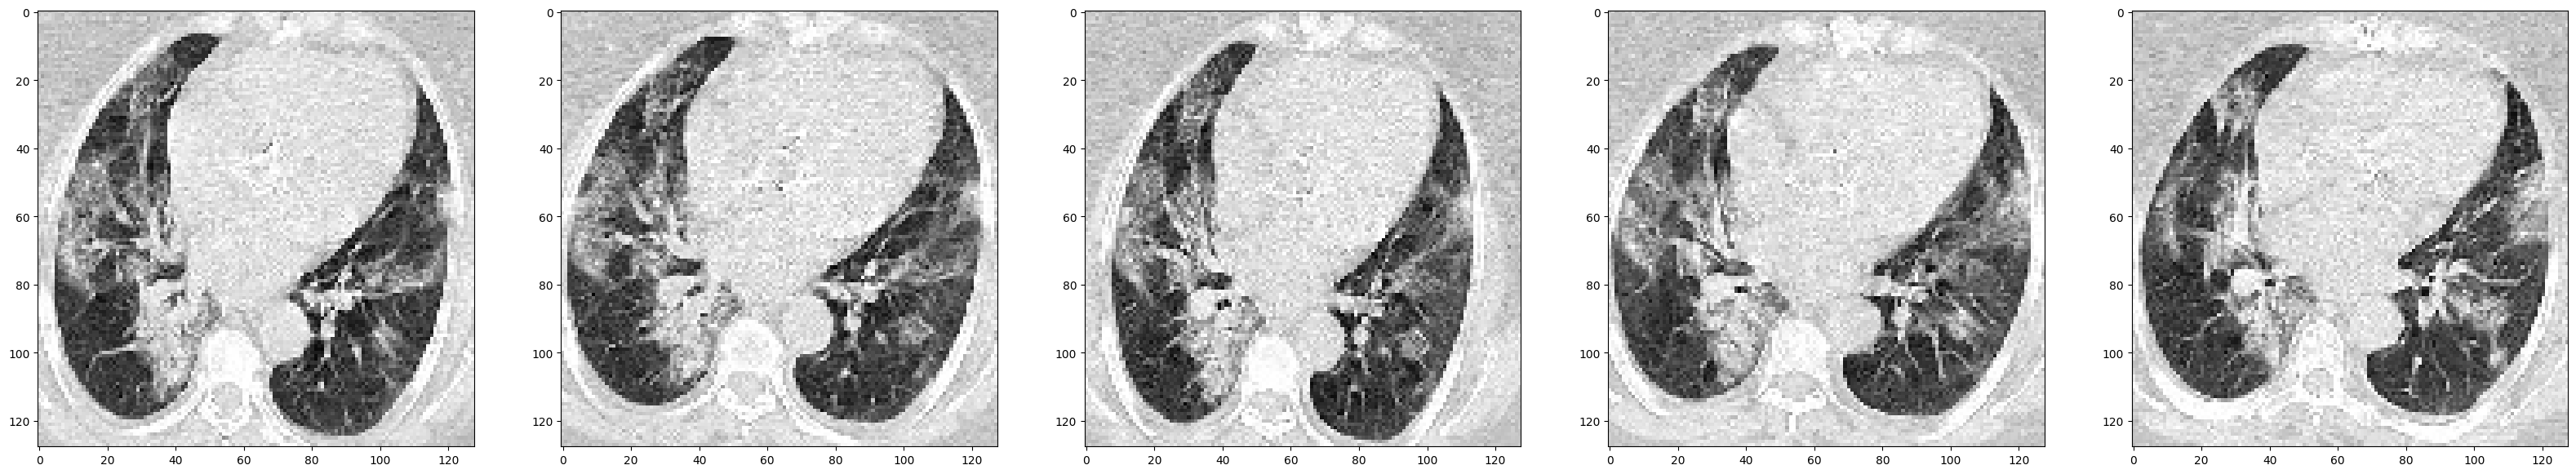

In [13]:
plot_img(train_df)

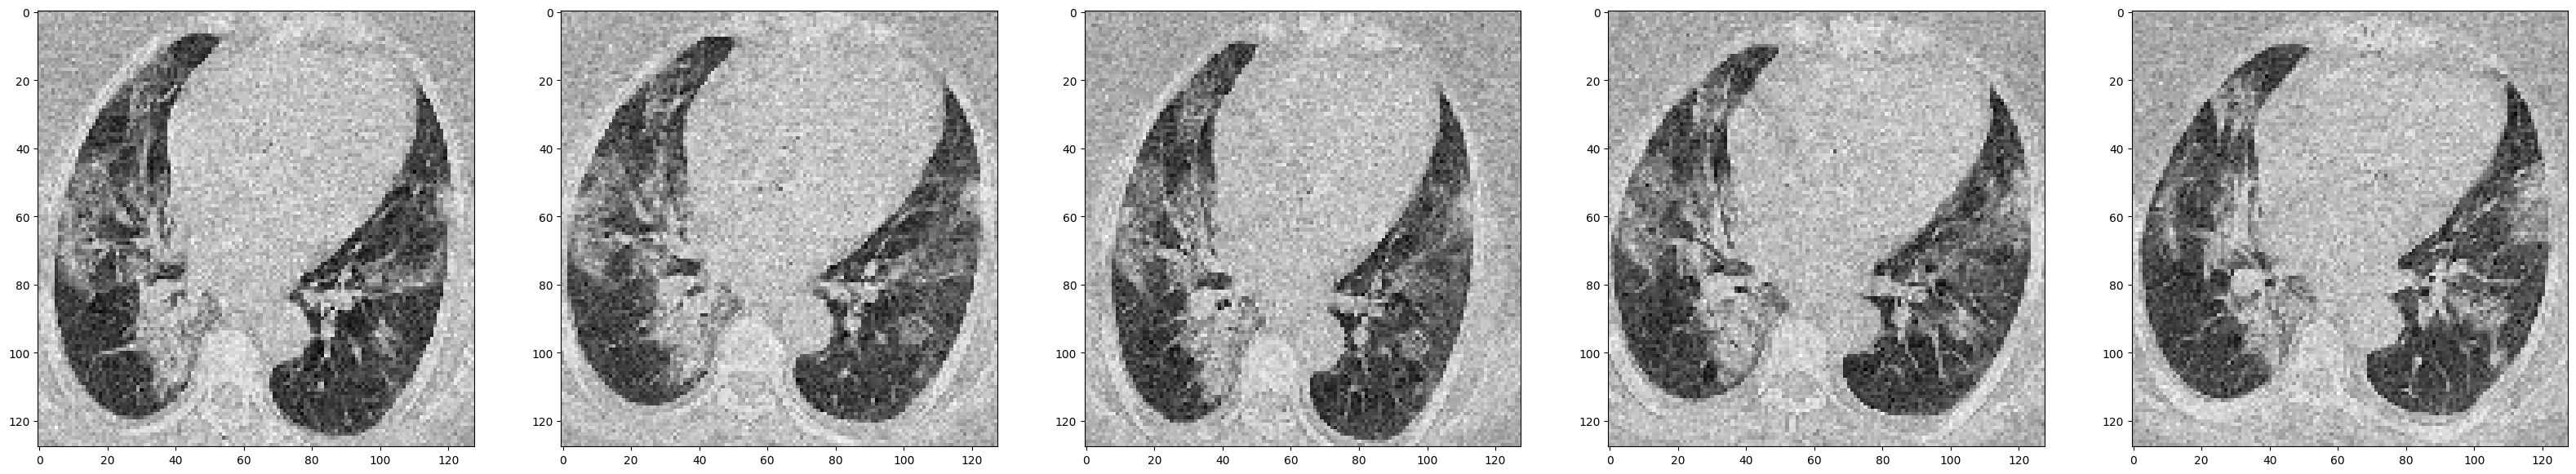

In [14]:
plot_img(noised_df)

In [15]:
noised_df.shape

(1262, 128, 128, 1)

In [17]:
xnoised=noised_df[:800]
xtest=noised_df[800:]

In [18]:
xclean = train_df[:800]

In [19]:
cleantest = train_df[800:]

In [20]:
xtest.shape

(462, 128, 128, 1)

Autoencoder based Denoising Model

In [21]:
def autoencoder():
  input_img=Input(shape=(128,128,1),name='image_input')
  #enoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  return autoencoder

In [22]:
model= autoencoder()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample1 (UpSampling2D)        │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample2 (UpSampling2D)        │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [23]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xclean, epochs=5, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - loss: 0.5756 - val_loss: 0.4895
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.4890 - val_loss: 0.4846
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.4851 - val_loss: 0.4840
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - loss: 0.4845 - val_loss: 0.4814
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - loss: 0.4827 - val_loss: 0.4810


In [24]:
xtrain= train_df[800:]

Plot and Analyze Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


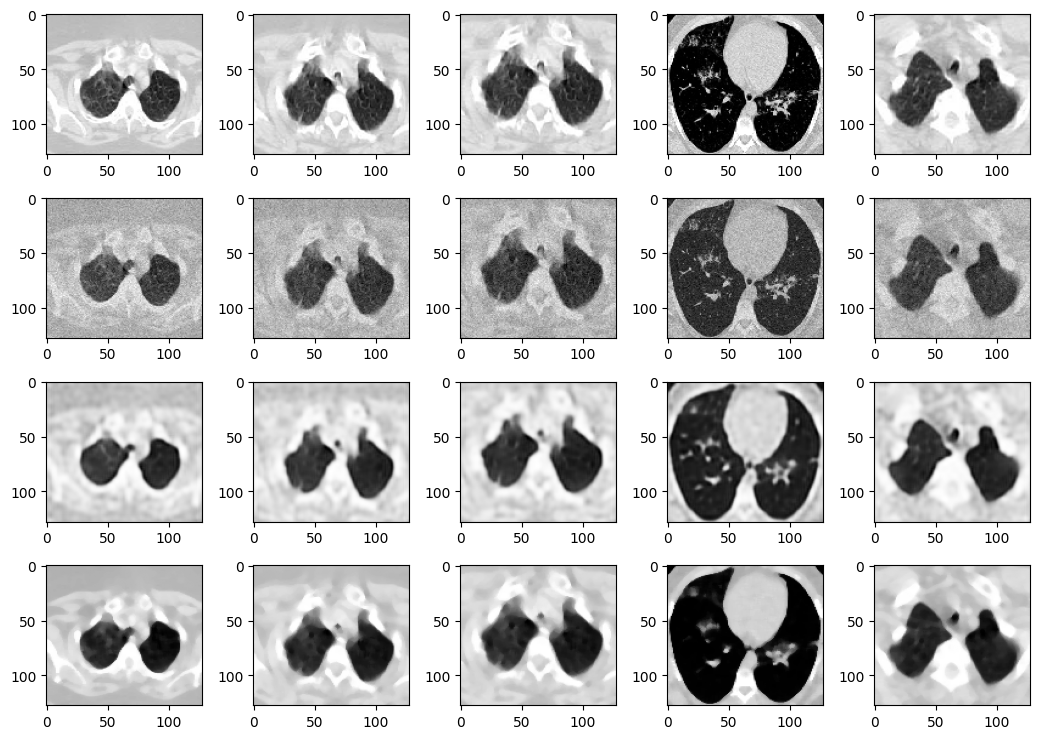

In [25]:
pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (128,128)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (128,128)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (128,128)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

Comparison of our Denoising model with pre-existing denoising techniques

Text(0.5, 1.0, 'Bilateral Filter')

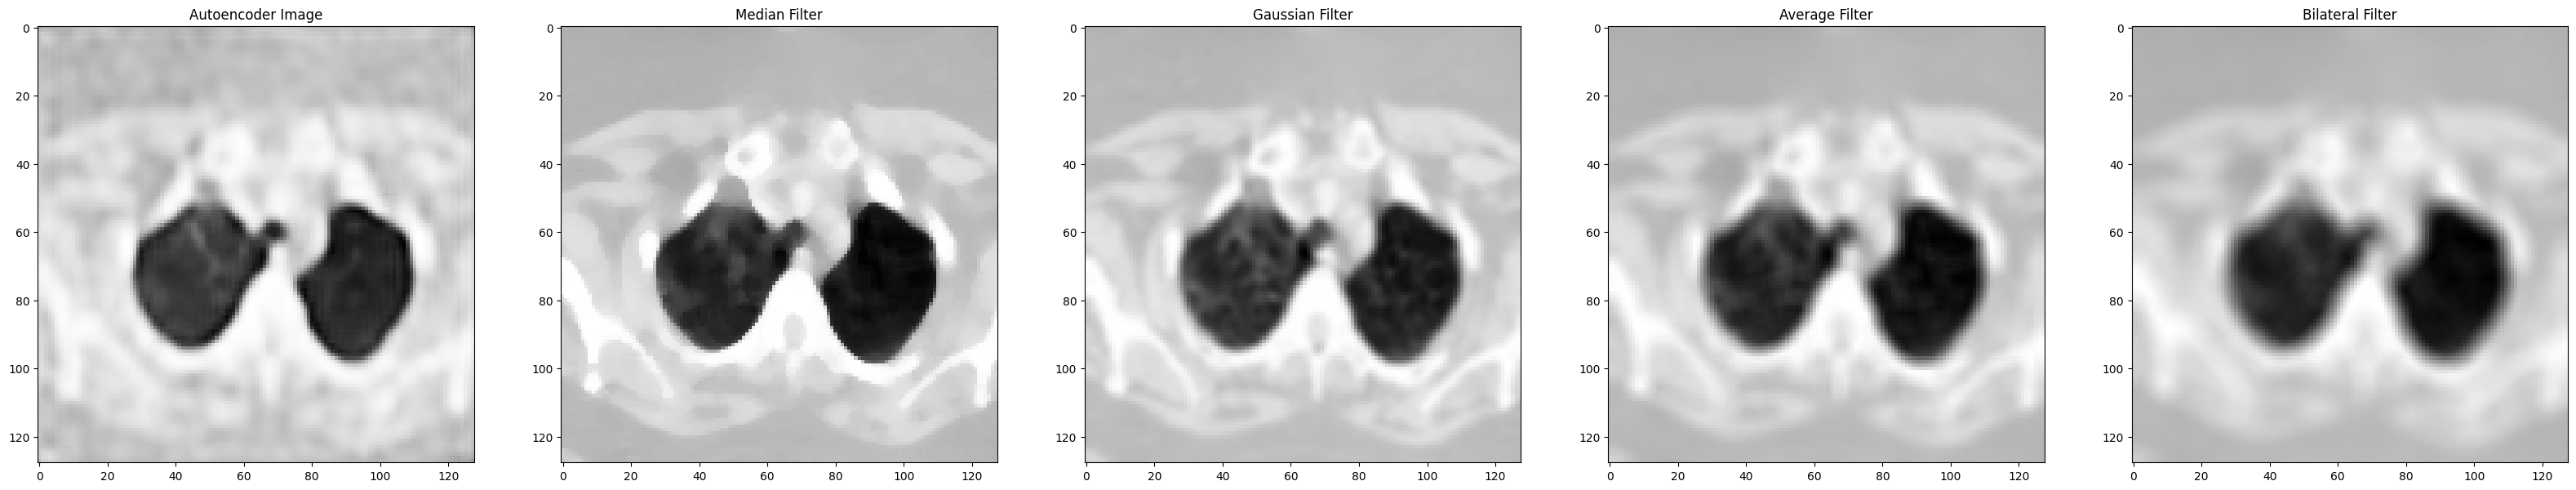

In [26]:
median_blur = cv2.medianBlur(xtrain[0], (5))
gaussian_blur=cv2.GaussianBlur(xtrain[0],(5,5),0)
average_blur=cv2.blur(xtrain[0],(5,5))
bilateral_filter=cv2.bilateralFilter(xtrain[0],9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0].reshape(128,128), cmap='gray')
ax[0].set_title('Autoencoder Image')
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter')
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter')
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter')

Text(0.5, 1.0, 'Average Blur')

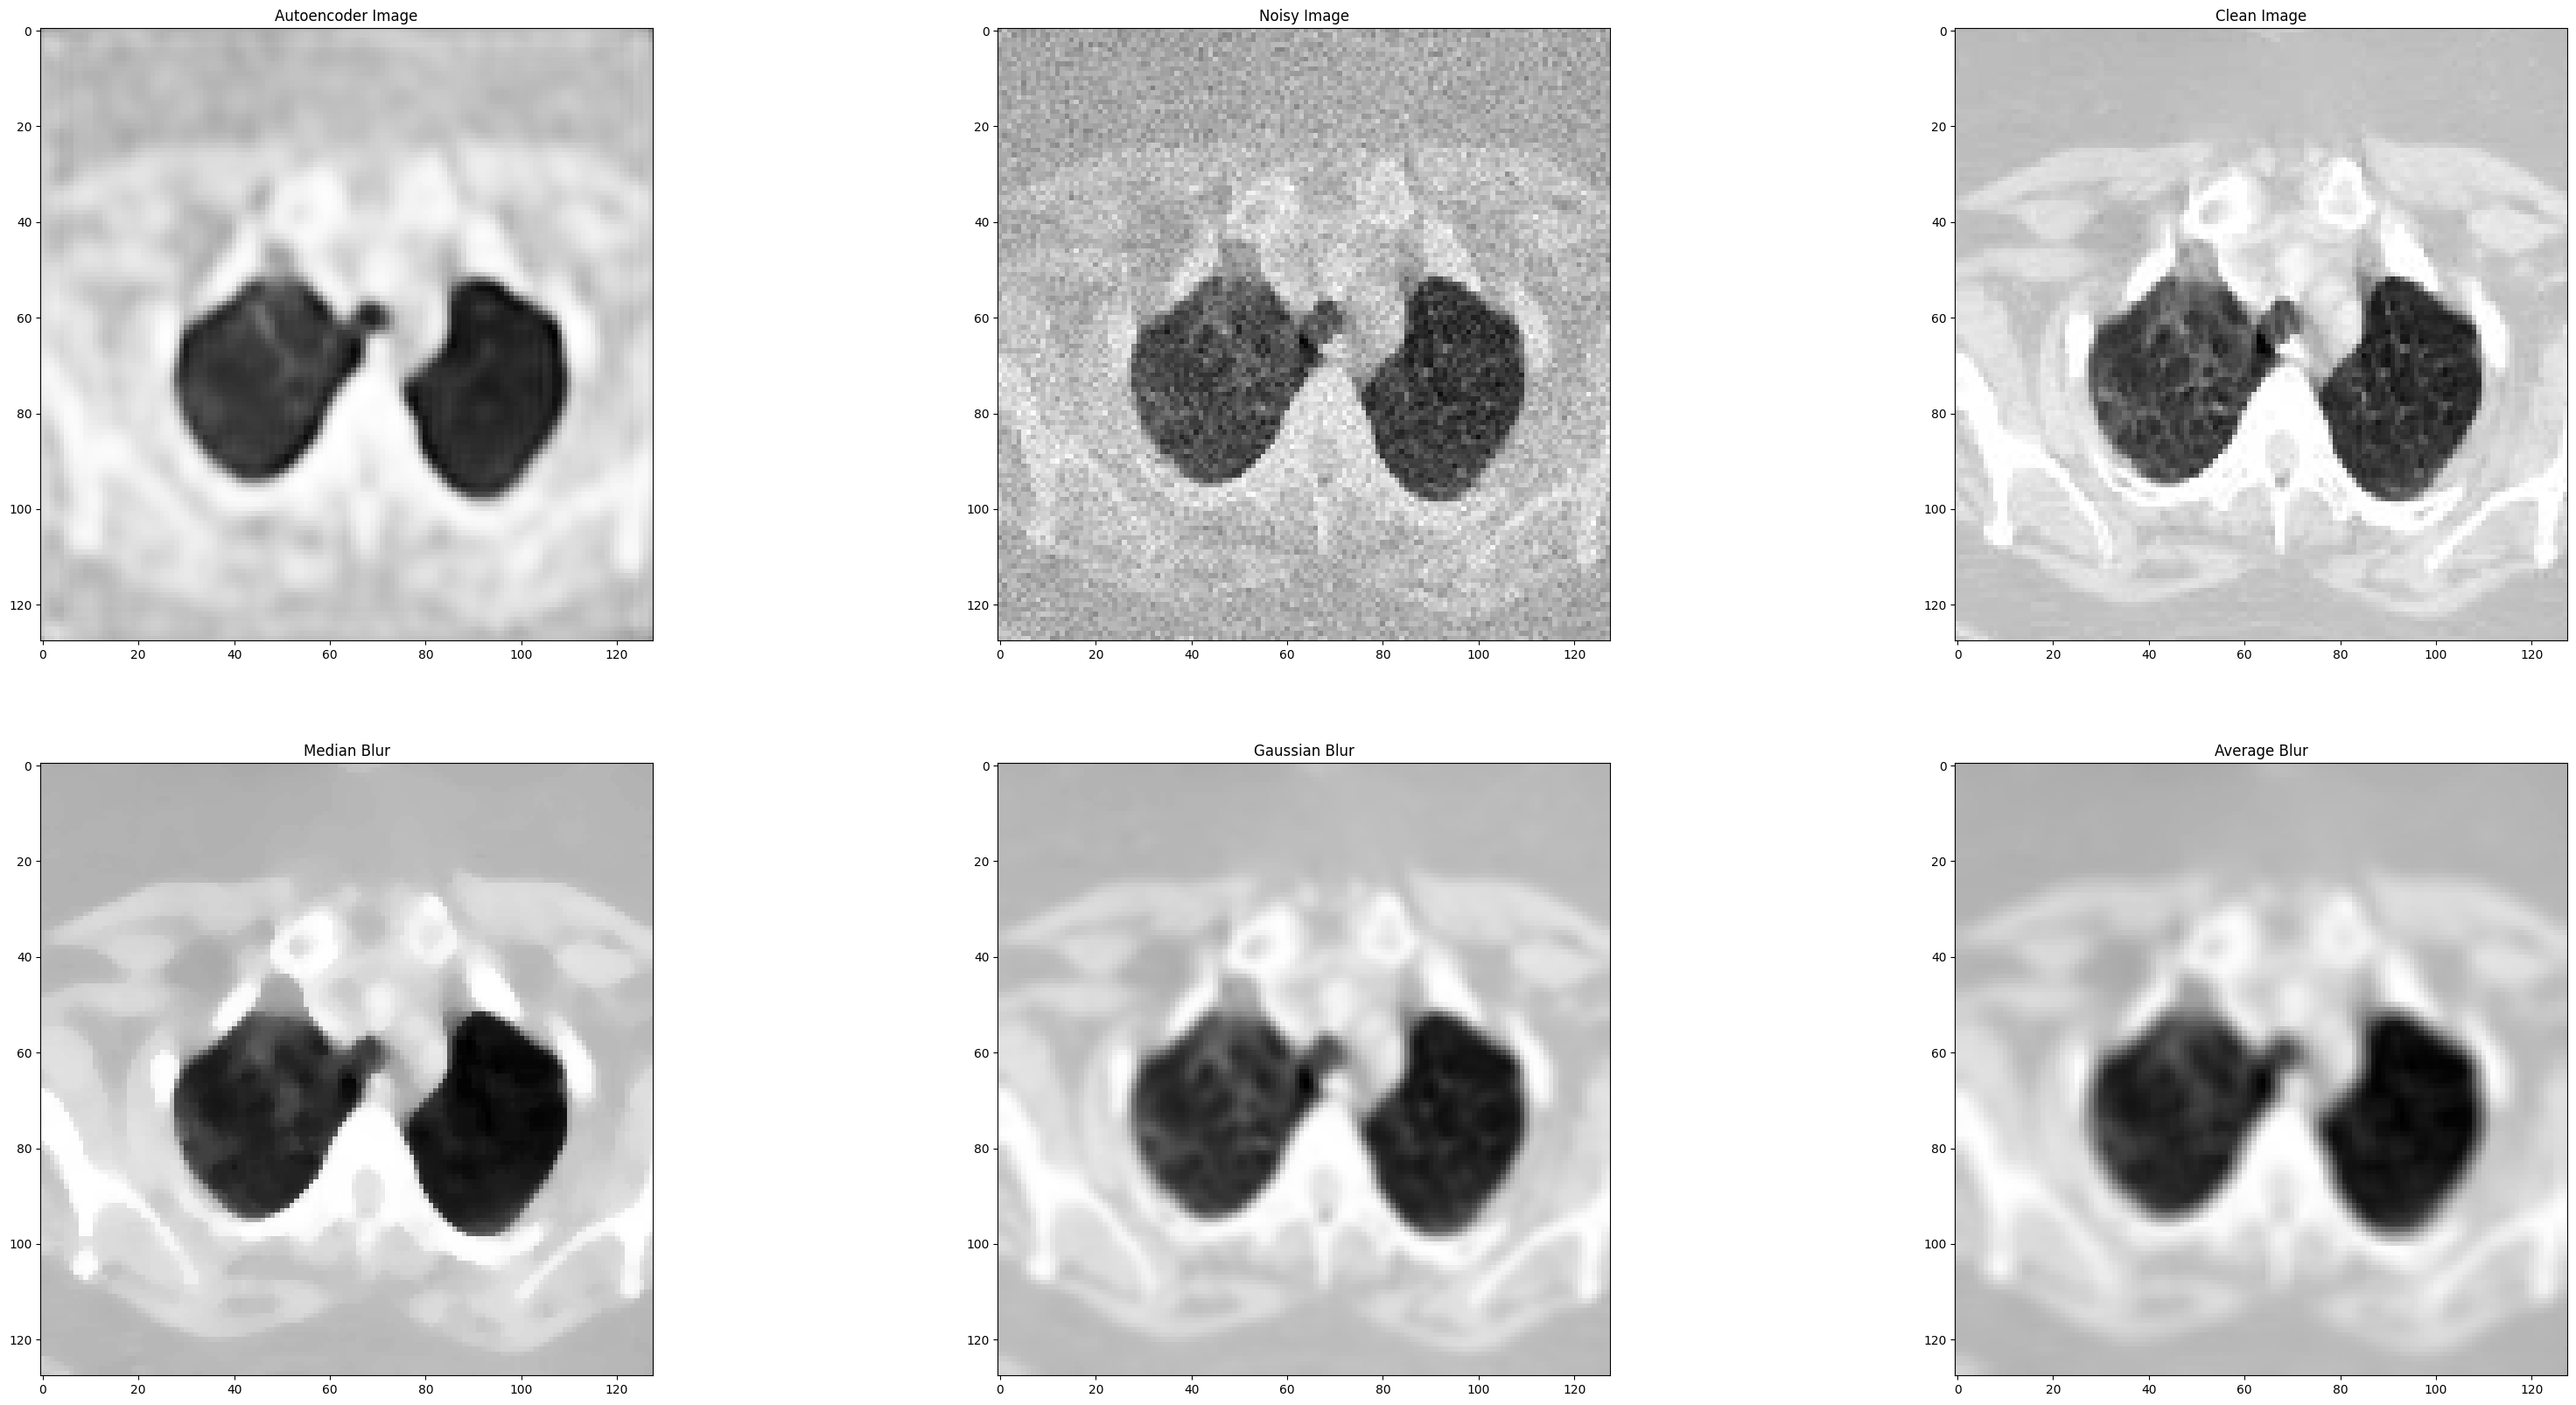

In [27]:
median_blur = cv2.medianBlur(xtrain[0], (5))
gaussian_blur=cv2.GaussianBlur(xtrain[0],(5,5),0)
average_blur=cv2.blur(xtrain[0],(5,5))
bilateral_filter=cv2.bilateralFilter(xtrain[0],9,75,75)
f,ax=plt.subplots(2,3)
f.set_size_inches(40,20)
ax[0][0].imshow(pred[0].reshape(128,128), cmap='gray')
ax[0][0].set_title('Autoencoder Image')
ax[0][1].imshow(xtest[0].reshape(128, 128), cmap= 'gray')
ax[0][1].set_title('Noisy Image')
ax[0][2].imshow(train_df[800],cmap='gray')
ax[0][2].set_title('Clean Image')
ax[1][0].imshow(median_blur,cmap='gray')
ax[1][0].set_title('Median Blur')
ax[1][1].imshow(gaussian_blur,cmap='gray')
ax[1][1].set_title('Gaussian Blur')
ax[1][2].imshow(average_blur, cmap= 'gray')
ax[1][2].set_title('Average Blur')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Comparing the PSNR values

In [28]:
  def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


value1 = PSNR(xtrain[0], median_blur)
value2 = PSNR(xtrain[0], pred[0])
value3 = PSNR(xtrain[0], gaussian_blur)
value4 = PSNR(xtrain[0], average_blur)
value5 = PSNR(xtrain[0], bilateral_filter)

print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")

PSNR values
Autoencoder Image : 77.46761153535992 dB
Median Filter Image : 60.53155019266289 dB
Gaussian Filter Image : 60.639536114970724 dB
Average Filter Image : 60.73561168844186 dB
Bilateral Filter Image : 60.864749739654386 dB


In [29]:
autoencoded_img_mtrx = pred[0].reshape(128, 128)


In [30]:
np.savetxt("autoencoded_img_mtrx.txt", autoencoded_img_mtrx, fmt="%.6f")

In [31]:
xtest[0].shape

(128, 128, 1)

In [32]:
noisy_img_mtrx = xtest[0].reshape(128, 128)

In [33]:
np.savetxt("noisy_img_mtrx.txt", noisy_img_mtrx, fmt="%.6f")

CONCLUSION:
  Our autoencoder-based denoising model achieved superior PSNR compared to traditional denoising techniques that do not learn from data. Unlike fixed filters, autoencoders adaptively learn to adjust convolutional weights based on the significance and detail of image regions. This allows the model to apply stronger smoothing to less critical areas while preserving fine details in more important regions, resulting in more effective and context-aware denoising.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from PIL import Image

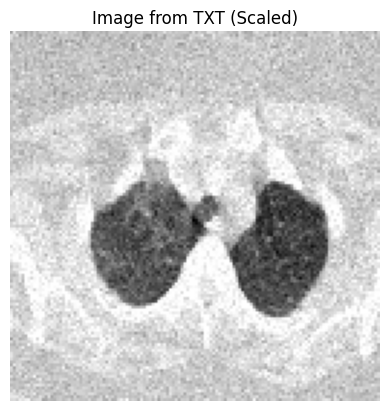

In [36]:
image_matrix = np.loadtxt('/content/noisy_img_mtrx.txt', delimiter=' ')

# Scale to 0–255 and convert to uint8
image_matrix = (image_matrix * 255).clip(0, 255).astype(np.uint8)

plt.imshow(image_matrix, cmap='gray')
plt.title("Image from TXT (Scaled)")
plt.axis('off')
plt.show()

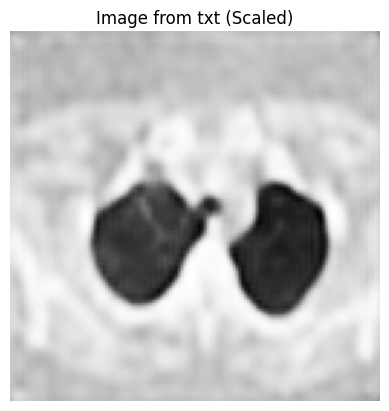

In [37]:
image_matrix = np.loadtxt('/content/autoencoded_img_mtrx.txt', delimiter=' ')

# Scale to 0–255 and convert to uint8
image_matrix = (image_matrix * 255).clip(0, 255).astype(np.uint8)

plt.imshow(image_matrix, cmap='gray')
plt.title("Image from txt (Scaled)")
plt.axis('off')
plt.show()

In [38]:
def calculate_entropy(csv_path):
    pixel_array = np.loadtxt(csv_path, delimiter=' ')
    pixels = pixel_array.flatten()
    pixels = (pixels * 255).clip(0, 255).astype(np.uint8)
    # Calculate histogram with 256 bins (0–255)
    histogram, _ = np.histogram(pixels, bins=256, range=(0, 256), density=True)
    # Remove zero entries to avoid log(0)
    histogram = histogram[histogram > 0]
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

In [39]:
#Setup

# Step 2: Define DCT and Quantization
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

Q = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

# Step 3: JPEG Compression function
def jpeg_compress_grayscale(img, quality=50):
    h, w = img.shape
    compressed = np.zeros((h, w), dtype=np.float32)

    # Adjust quantization based on quality
    scale = 5000 / quality if quality < 50 else 200 - 2 * quality
    Q_scaled = np.floor((Q * scale + 50) / 100)
    Q_scaled[Q_scaled == 0] = 1

    non_zero_count = 0  # For compression ratio calculation

    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img[i:i+8, j:j+8]
            if block.shape != (8, 8): continue
            block = block - 128
            dct_block = dct2(block)
            quantized = np.round(dct_block / Q_scaled)
            non_zero_count += np.count_nonzero(quantized)  # Only store non-zero coefficients
            dequantized = quantized * Q_scaled
            idct_block = idct2(dequantized) + 128
            compressed[i:i+8, j:j+8] = np.clip(idct_block, 0, 255)

    return compressed.astype(np.uint8), non_zero_count

# Step 4: Run compression
def analyze():
    compressed_img, non_zero_coeffs = jpeg_compress_grayscale(image_matrix, quality=50)

# Step 5: Calculate Compression Ratio
    original_size = image_matrix.size  # each pixel = 1 byte in grayscale uint8
    compressed_size = non_zero_coeffs  # storing only non-zero coefficients from DCT

    compression_ratio = original_size / compressed_size

    print(f"Original size (bytes): {original_size}")
    print(f"Compressed size (approx non-zero coeffs): {compressed_size}")
    print(f"Compression ratio: {compression_ratio:.2f}")

# Step 6: Show compressed image
    plt.imshow(compressed_img, cmap='gray')
    plt.title("JPEG Compressed Image")
    plt.axis('off')
    plt.show()
    return


In [40]:
# Step 1: Load and scale image
image_matrix = np.loadtxt('/content/autoencoded_img_mtrx.txt', delimiter=' ')
image_matrix = (image_matrix * 255).clip(0, 255).astype(np.uint8)

In [41]:
calculate_entropy('/content/autoencoded_img_mtrx.txt')

np.float64(6.369278371532123)

Original size (bytes): 16384
Compressed size (approx non-zero coeffs): 2541
Compression ratio: 6.45


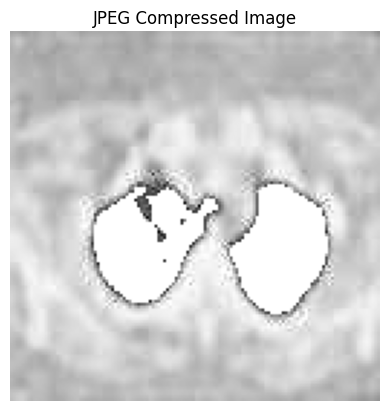

In [42]:
analyze()

In [43]:
image_matrix = np.loadtxt('/content/noisy_img_mtrx.txt', delimiter=' ')
image_matrix = (image_matrix * 255).clip(0, 255).astype(np.uint8)

In [44]:
calculate_entropy('/content/noisy_img_mtrx.txt')

np.float64(6.754850290930103)

Original size (bytes): 16384
Compressed size (approx non-zero coeffs): 4851
Compression ratio: 3.38


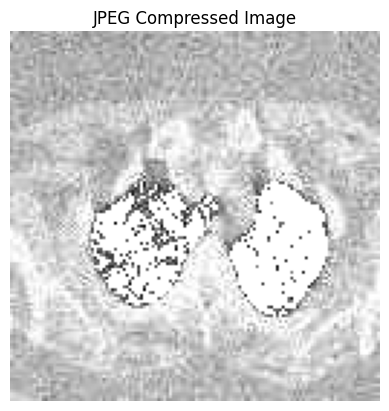

In [45]:
analyze()

CONCLUSION: Our autoencoder-based denoising model achieved superior PSNR compared to traditional denoising techniques that do not learn from data. Unlike fixed filters, autoencoders adaptively learn to adjust convolutional weights based on the significance and detail of image regions. This allows the model to apply stronger smoothing to less critical areas while preserving fine details in more important regions, resulting in more effective and context-aware denoising.

CONCLUSION: Our autoencoded image achieved a higher compression rate compared to directly compressing the noisy image. This improvement stems from the fact that noisy images have higher entropy, making them less compressible. In contrast, our autoencoder reduces this entropy by removing noise and redundancy before compression. As a result, for the same level of psychovisual redundancy exploitation, fewer bits per source symbol are required for the autoencoded image than for the noisy one. This allows us to achieve better compression while preserving essential features and discarding irrelevant or noisy data.

USES: This technique can be applied to efficiently compress and store medical images with minimal distortion, ensuring that critical tasks such as tumor segmentation and diagnosis remain accurate. By preserving essential details while reducing redundant information, it helps lower storage costs without compromising clinical utility.